# Load Model and Libraries

In [ ]:
import pandas as pd
import re
import json
import asyncio
import aiofiles
from vllm.engine.async_llm_engine import AsyncLLMEngine
from vllm.engine.arg_utils import AsyncEngineArgs
from vllm import LLM, SamplingParams
import random
import argparse
from utils import extract_items, llama_callable

engine_args = AsyncEngineArgs(
    model="meta-llama/Meta-Llama-3-8B-Instruct",
    gpu_memory_utilization=0.95
)
engine = AsyncLLMEngine.from_engine_args(engine_args)

In [ ]:
await llama_callable(engine, "What is the capital of France?")

# Prompting

In [ ]:
import pandas as pd
import json

# Select a partition from ["att", "obj", "rel"]
partitions = "att"

# Replace /path/to/data with path to the data
# NOTE: this expects the data csv's as output from the generation steps. This is not in the same format as the clean published dataset.
data_csv_path = "/path/to/output_data/replace-<PART>.csv".replace("<PART>", partitions)
save_path = "/path/to/output_data/replace-<PART>_ANNOTATED.csv".replace("<PART>", partitions)

# load partition
data = pd.read_csv(data_csv_path)
len(data)

In [ ]:
system_prompt = """You are an insightful assistant, for the question/answer pair provided by the user, pick a question format and question topic from the list below:
Question Format:
- hallucination: the question asks if something is visible or not, and the answer is NO, or that it is not visible/present (e.g. "Is there a cat in the room?" "No, there is no cat in the room.")
- misconception: the question asks about an attribute of an object, but that object is not present (e.g. "What color is the cat?" "There is no cat.")
- non-determinable: the question asks for something that cannot be distinguished (e.g. Is the cat in motion? "I cannot tell." OR "It is unclear.")
- selective: any other questions that do not fall into the above categories

Question Topics:
- lighting: the question asks about the lighting or direction of the light (e.g. "Is the cat's shadow sharp?" "No, the shadow is diffused.")
- clothing: the question asks about an what is being worn (e.g. "Is the cat wearing a hat?" "No, the cat is not wearing a hat.")
- attribute: the question asks about the presence or visibility of an attribute of an object (e.g. "Does the cat have white whiskers?" "No, the cat has black whiskers.")
- emotion: the question asks an opinion of what is observed (e.g. "What makes this room cozy?" "The fireplace makes the room cozy.")
- attention: the question asks about the attention of a person or object (e.g. "Which direction is the cat looking?" "The cat is looking out the window.")
- color: the question asks about the color of an object (e.g. "What color is the cat?" "The cat is black.")
- scene: the question asks about the location of the scene (e.g. "Is this indoor or outdoor?" "This is indoor.")
- count: the question asks about the number of objects (e.g. "How many cats are there?" "There are two cats.")
- behavior: the question asks about action or behavior (e.g. "Is the moving around?" "No, the cat is sleeping.")
- proximity: the question asks about the spatial relation between two objects (e.g. "Is the cat near the window?" "Yes, the cat is near the window.")

Do not confuse formats with topics.
Respond with a JSON object with the following format:
{
    "question_format": "format",
    "question_topic": "topic"
}
"""

In [ ]:
sem = asyncio.Semaphore(30)

# get result for all questions
async def get_result(ind):
    async with sem:
        for _ in range(5):
            try:
                question = data.iloc[ind]["question"]
                options = extract_items(data.iloc[ind]["text_options"])
                if data.iloc[ind]["correct"] == "A":
                    correct = options[0]
                else:
                    correct = options[1]
                prompt = "Question: " + question + "\nOptions: " + ", ".join(options) + "\nCorrect: " + correct + "\n" + system_prompt
                result = await llama_callable(engine, prompt, system_prompt=system_prompt, max_tokens=40, temperature=0.2)
                result_json = json.loads(result)
                return question, correct, result_json
            except:
                pass
    print("Failed", ind)
    return None, None, None

tasks = [get_result(ind) for ind in range(len(data))]
results = await asyncio.gather(*tasks)

# Processing Results

In [ ]:
# add results to dataframe
data["question_format"] = None
data["question_topic"] = None

for i, (question, correct, result) in enumerate(results):
    if result is not None:
        data.at[i, "question_format"] = result["question_format"]
        data.at[i, "question_topic"] = result["question_topic"]

data.to_csv(save_path, index=False)

# Manual Reassignment and Plotting Distributions

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Select a partition from ["att", "obj", "rel"]
partition = "obj"

data_base_path = "/path/to/data/replace-<PART>_HUMAN_FILTER_ANNOTATED.csv"

data = pd.read_csv(data_base_path.replace("<PART>", partition))

In [ ]:
# Identify Mislabels and Reassignment
replace_format = {"attribute": "selective", "uncategorized": "selective", "attention": "selective", "emotion": "selective", "count": "selective", "lighting": "selective", "proximity": "selective", "scene": "selective", "behavior": "selective", "clothing": "selective", "color": "selective"}
replace_topic = {"uncategorized": "attribute", "visibility": "attribute", "weather": "scene"}
data['question_format'] = data['question_format'].replace(replace_format)
data['question_topic'] = data['question_topic'].replace(replace_topic)
data.to_csv(data_base_path.replace("<PART>", partition), index=False)

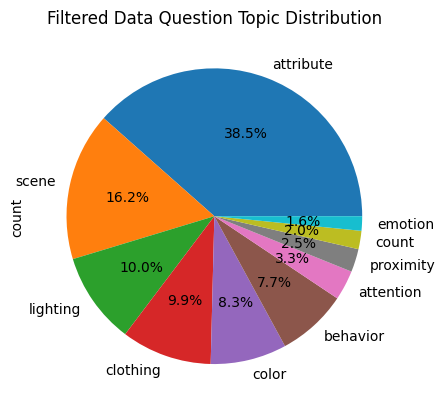

In [53]:
partitions = ["att", "obj", "rel"]

# Replace /path/to/data with path to the data /path/to/data
data_base_path = "/dccstor/mm-instruct1/jacobspace/vl-align/filtered/replace-<PART>_HUMAN_FILTER_ANNOTATED.csv"

data_full_partitions = pd.concat([pd.read_csv(data_base_path.replace("<PART>", part)) for part in partitions])

# show pie chart of question format (pick either question_format or question_topic)
filtered_topics = data_full_partitions["question_topic"].value_counts()
filtered_topics.plot.pie(autopct="%.1f%%")
plt.title("Filtered Data Question Topic Distribution")
plt.show()

# Plotting Error Distributions

In [1]:
from utils import extract_model_performance, plot_model_mistakes
import pandas as pd

# NEED <PART> in model path for the partitions
data_base_path = "/path/to/data/replace-<PART>_HUMAN_FILTER_ANNOTATED.csv"

# model_perf files are the output csv's extracted from the pickle files produced by prompt_negatives/vlm_eval_gpt4v.py
# Requires <PART> and <MODEL> in the path
model_perf_base_path_template = "/path/to/results/replace_<PART>_HUMAN_FILTER/{model}/generate/results_dataframe.pkl"

In [ ]:
partitions = ["att", "obj", "rel"]
# load each partition
data = {}
replacements_topic = {"weather": "scene", "visibility": "scene", "uncategorized": "attribute"}
replacements_format = {"proximity": "selective", "attribute": "selective", "emotion": "selective", "count": "selective", "attention": "selective", "lighting": "selective", "behavior": "selective", "uncategorized": "selective"}

for partition in partitions:
    data_path = data_base_path.replace("<PART>", partition)
    data[partition] = pd.read_csv(data_path)
    data[partition]["question_topic"] = data[partition]["question_topic"].apply(lambda x: replacements_topic.get(x, x))
    data[partition]["question_format"] = data[partition]["question_format"].apply(lambda x: replacements_format.get(x, x))
    print(partition, len(data[partition]))

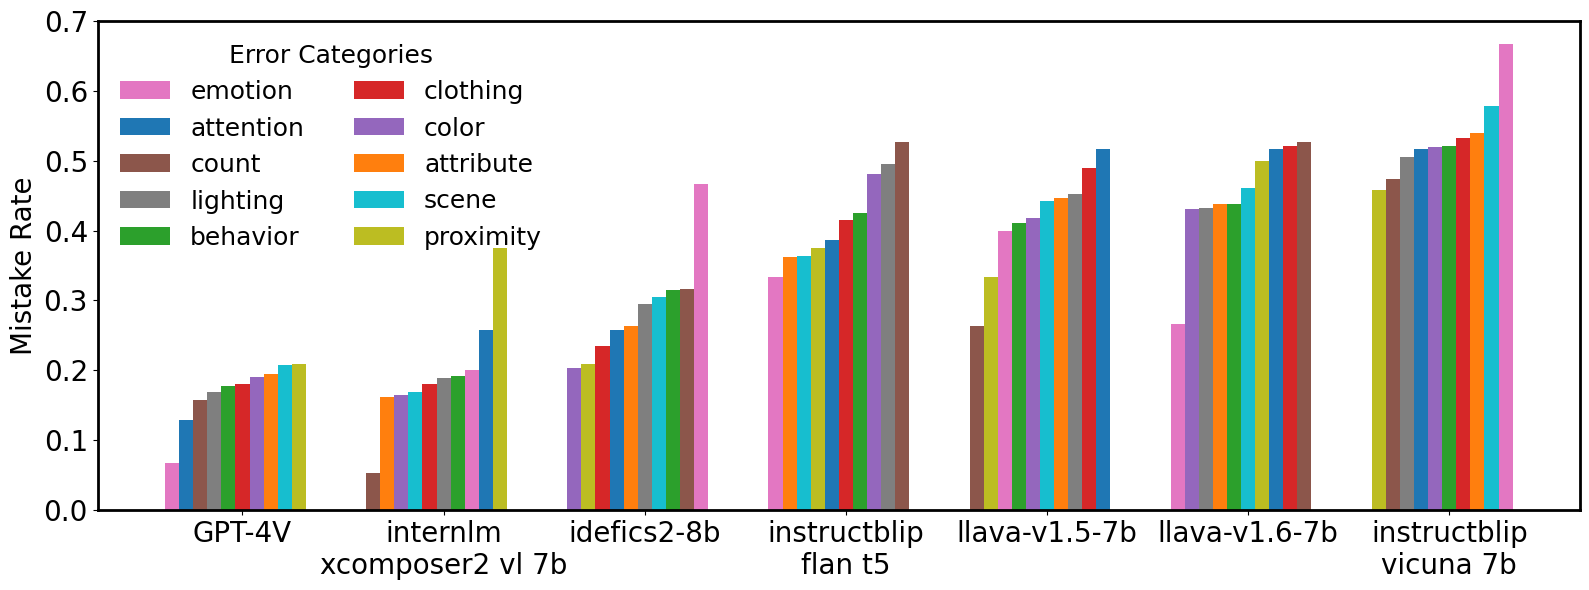

In [5]:
models = ["llava-v1.5-7b", "llava-v1.6-7b", "instructblip_flan_t5", "instructblip_vicuna_7b", "internlm_xcomposer2_vl_7b", "idefics2-8b", "gpt"]
performance = extract_model_performance(models, partitions, data, model_perf_base_path_template, category="question_topic")
plot_model_mistakes(performance, models, title="Error Categories")